# Практика по A/B тестированию

### **Лекция № 8 "Модели ML в production"**

![d](https://www.meme-arsenal.com/memes/9a92e4f5c51c566b9d94e90f0914a3c2.jpg)

In [1]:
import numpy as np
from math import ceil

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t
from scipy.stats import norm
from scipy.stats import mannwhitneyu
from scipy.stats import shapiro
from statsmodels.stats import power
from statsmodels.stats.proportion import (proportion_effectsize,
                                          proportions_ztest,
                                          proportion_confint)

**Словарь данных:**
- user id: Идентификатор пользователя (уникальный).
- test group: Если "ad", то человек видел рекламу, если "psa", то он видел только объявление государственной службы.
- converted: Если человек купил продукт, то True, иначе False.
- total ads: Количество рекламы, увиденной человеком.
- most ads day: День, в который человек увидел наибольшее количество рекламы.
- most ads hour: Час дня, в который человек увидел наибольшее количество рекламы.

## **Задача 1.** 
Проанализируйте структуру данных и проведите их предобработку:
- Исследуйте структуру данных;
- Преобразуйте столбцы к необходимым типам данных.
- Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.
- Проверьте, есть ли пользователи, которые в процессе A/Bтеста попали в обе группы. Если да, исключите пользователей, оказавшихся в обеих группах.

In [4]:
df = pd.read_csv('marketing_AB.csv', sep=',')
df.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [6]:
df.isnull().sum()

Unnamed: 0       0
user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

Пропуски в данных отсуствуют

Удаляем первый столбец, он не несет информативности, в столбцах converted и most ads day меняем значения по словарям {True:1, False:0} и {'Monday':1, 'Tuesday':2, 'Friday':5, 'Saturday':6, 'Wednesday':3, 'Sunday':7, 'Thursday':4} соответсвенно

In [7]:
dict_1={True:1, False:0}
df['converted']=df['converted'].replace(dict_1)

dict_2={'Monday':1, 'Tuesday':2, 'Friday':5, 'Saturday':6, 'Wednesday':3, 'Sunday':7, 'Thursday':4}
df['most ads day']=df['most ads day'].replace(dict_2)

df=df.drop(columns=['Unnamed: 0'], axis=1)

Проверим, есть ли пользователи, у которых несколько сессий:

In [8]:
session_counts = df['user id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'В датасете {multi_users} пользователей, которые встречаются несколько раз')

В датасете 0 пользователей, которые встречаются несколько раз


## **Задача 2.** 
Сделайте первичный анализ результатов A/B-тестирования
Рассчитайте вспомогательные показатели для контрольной и тестовой групп:

- количество посещений сайта;
- суммарное количество совершённых покупок;
- Сделайте промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной страницы? Можно ли говорить о сбалансированности выборок?



In [9]:
data = df.groupby(['test group']).agg({
    'user id':'count',
    'converted':'sum',
}).reset_index().rename(columns={'user id': 'users_count'})

data

,test group,users_count,converted
0,ad,564577,14423
1,psa,23524,420


**Вывод.** Количество посещений несопоставимо
Выборка несбалансированна, в первой группе значительно больше пользователей.

## **Задача 3.** 
В каждой из групп рассчитайте ключевые показатели:

- конверсия;
- среднее количество рекламы, увиденной пользователем.

Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего количества увиденной рекламы в каждой из групп. По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [10]:
data = df.groupby(['test group']).agg({
    'user id':'count',
    'converted':'sum',
    'total ads':'sum'
}).reset_index().rename(columns={'user id': 'users_count'})
data['mean_ads']=data['total ads']/data['users_count']
data['mean_ads']=data['mean_ads'].round(2)

data['conversion']=data['converted']*100/data['users_count']
data['conversion']=data['conversion'].round(2)
data

,test group,users_count,converted,total ads,mean_ads,conversion
0,ad,564577,14423,14014701,24.82,2.55
1,psa,23524,420,582481,24.76,1.79


In [11]:
daily_data = df.groupby(['most ads day','test group']).agg({
    'user id':'count',
    'converted':'sum'
}).reset_index().rename(columns={'user id': 'users_count'})
daily_data['conversion']=daily_data['converted']*100/daily_data['users_count']
daily_data['conversion']=daily_data['conversion'].round(2)

daily_data.sort_values(by='most ads day', ascending=True)


,most ads day,test group,users_count,converted,conversion
0,1,ad,83571,2778,3.32
1,1,psa,3502,79,2.26
2,2,ad,74572,2270,3.04
3,2,psa,2907,42,1.44
4,3,ad,77418,1963,2.54
5,3,psa,3490,55,1.58
6,4,ad,79077,1711,2.16
7,4,psa,3905,79,2.02
8,5,ad,88805,1995,2.25
9,5,psa,3803,62,1.63


In [12]:
conversion_piv = daily_data.groupby('test group')['conversion'].agg(
    ['mean', 'median']
)
display(conversion_piv)

,mean,median
test group,,
ad,2.557143,2.46
psa,1.770000,1.63


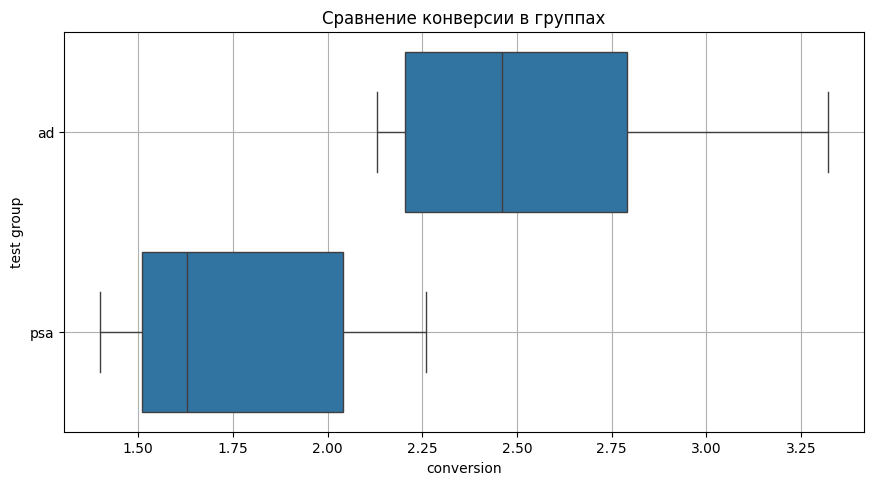

In [13]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_data, x='conversion', y='test group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid(True);

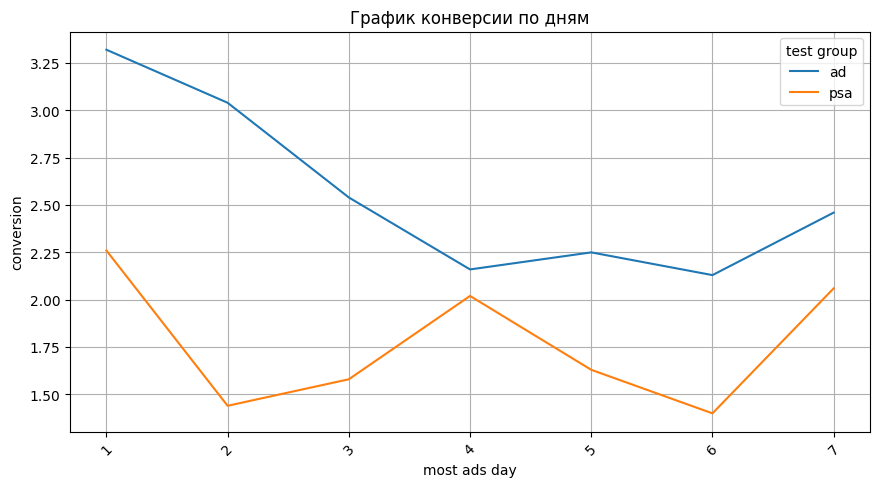

In [14]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_data,
    x='most ads day',
    y='conversion',
    hue='test group', 
    ax=ax
)
# задаём подпись к графику
ax.set_title('График конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid(True);


**Вывод.** На первый взгляд эффективнее первая группа по показателю конверсии, по среднему значению и медианному.

Но при построении графиков видно что разброс у первой группы больше чем у второй и показатель конверсии нестабилен во времени.

## **Задача 4.** 
Проведите статистический анализ результатов A/B-тестирования: cформулируйте статистические гипотезы, соответствующие поставленным бизнес-вопросам, и выберите статистический тест для их проверки.


Не забудьте проверить данные на нормальность там, где это необходимо.

С помощью аппарата статистических тестов определите:

Есть ли статистическая разница между конверсиями в группах А и B?

Есть ли статистическая разница между средними количествами увиденной рекламы в группах А и B?

In [15]:
#Предварительно сбалансируем наши выборки
p_control=conversion_piv['mean']['psa']/100
p_test=conversion_piv['mean']['ad']/100

effect_size = proportion_effectsize(p_control, p_test)


# Какого размера выборок было бы достаточно?
alpha = 0.05
beta = 0.2 #желаемая

sample_size = power.TTestIndPower().solve_power(effect_size=effect_size, alpha=alpha, power=1-beta, nobs1= None)
print(f'Выборки в {round(sample_size)} будет достаточно для проведения теста')

Выборки в 5320 будет достаточно для проведения теста


In [16]:
control_sample = df[df['test group']=='psa'].sample(n=ceil(sample_size), random_state=0)
treatment_sample = df[df['test group']=='ad'].sample(n=ceil(sample_size), random_state=0)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user id,test group,converted,total ads,most ads day,most ads hour
0,922723,psa,1,30,2,14
1,903370,psa,0,24,6,11
2,901579,psa,0,2,1,7
3,923298,psa,0,54,6,17
4,904742,psa,0,2,4,13
...,...,...,...,...,...,...
10635,1042502,ad,0,33,1,10
10636,1083716,ad,0,9,4,22
10637,1543208,ad,0,12,5,21
10638,1046701,ad,0,10,2,13


**Решение:**

Нулевая гипотеза : Нет существенной разницы между коэффициентами конверсии группы «AD» и группы «PSA».

Альтернативная гипотеза: Коэффициент конверсии группы «AD» значительно выше, чем коэффициент конверсии группы «PSA».

In [17]:
data = ab_test.groupby(['test group']).agg({
    'user id':'count',
    'converted':'sum',
    'total ads':'sum'
}).reset_index().rename(columns={'user id': 'users_count'})
data['mean_ads']=data['total ads']/data['users_count']
data['mean_ads']=data['mean_ads'].round(2)

data['conversion']=data['converted']*100/data['users_count']
data['conversion']=data['conversion'].round(2)
data

,test group,users_count,converted,total ads,mean_ads,conversion
0,ad,5320,140,130366,24.50,2.63
1,psa,5320,98,138011,25.94,1.84


In [18]:
#из датасета data забираем данные для каждой из тестовых групп
count_conversions_ad=data[data['test group']=='ad']['converted'].sum()
count_conversions_psa=data[data['test group']=='psa']['converted'].sum()

total_ads_ad=data[data['test group']=='ad']['total ads'].sum()
total_ads_psa=data[data['test group']=='psa']['total ads'].sum()

total_observations_ad=data[data['test group']=='ad']['users_count'].sum()
total_observations_psa=data[data['test group']=='psa']['users_count'].sum()

count_purchase = [count_conversions_ad, count_conversions_psa]
count_ads=[total_ads_ad, total_ads_psa]  
count_observation = [total_observations_ad, total_observations_psa] 



In [19]:
#  Выполняем Z-тест 
z_stat, p_value = proportions_ztest(count=count_purchase, nobs=count_observation)

# Определить результат теста
alpha = 0.05  # Уровень значимости

print(f'Z-Score: {z_stat:.2f}')
print(f'P-Value: {p_value:.3f}')

Z-Score: 2.75
P-Value: 0.006


**Вывод.** В нашем случае p-value = 0.00, что меньше 0.05. Поэтому мы можем отклонить нулевую гипотезу. Другими словами, группа AD имеет значительно более высокий коэффициент конверсии, чем группа PSA.

**Решение:**

Нулевая гипотеза : Нет существенной разницы между средними количествами увиденной рекламы группы «AD» и группы «PSA».

Альтернативная гипотеза: Есть существенной разницы между средними количествами увиденной рекламы группы «AD» и группы «PSA».

In [21]:
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро — Уилка для выборок
shapiro_result_a = shapiro(ab_test[ab_test['test group']=='ad']['total ads'])
shapiro_result_b = shapiro(ab_test[ab_test['test group']=='psa']['total ads'])
print('p-value группы ad', round(shapiro_result_a.pvalue, 2))
print('p-value группы psa', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value для группы ad с уровнем значимости
if shapiro_result_a.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе ad отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе ad является нормальным")

# сравниваем полученное p-value для группы B с уровнем значимости
if shapiro_result_b.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе psa отлично от нормального")
else:
    print("Принимаем нулевую гипотезу. Распределение в группе psa является нормальным")

p-value группы ad 0.0
p-value группы psa 0.0
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе ad отлично от нормального
Отвергаем нулевую гипотезу в пользу альтернативной. Распределение в группе psa отлично от нормального


c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [22]:
alpha = 0.05 # уровень значимости

# вычисляем результат теста Манна — Уитни для выборок
results = mannwhitneyu(
    x=data[data['test group']=='ad']['users_count'].sum(),
    y=data[data['test group']=='psa']['users_count'].sum(),
    alternative='two-sided'
)
print('p-value:', round(results.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if results.pvalue <= alpha:
    print("Отвергаем нулевую гипотезу в пользу альтернативной")
else:
    print("У нас нет оснований отвергнуть нулевую гипотезу")

p-value: 1.0
У нас нет оснований отвергнуть нулевую гипотезу


**Вывод.** В нашем случае p-value = 1, что , больше 0.05. Поэтому мы не можем отклонить нулевую гипотезу. Другими словами,нет существенной разницы между средними количествами увиденной рекламы.

In [1]:
# добавить проверку на нормальность для числа покупок + подкрепить стат. тестом

## **Задача 5.**

Подкрепите результаты статистических тестов, построив 95 % доверительные интервалы для:

- конверсий в каждой из групп;
- разницы конверсий в группах;
- среднего количества увиденной рекламы в группах А и B.

Проинтерпретируйте построенные доверительные интервалы для конверсий и среднего количества увиденной рекламы группах. Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

In [23]:
# фильтруем данные группы ad
a_data = df[df['test group']=='ad']
# фильтруем данные группы psa
b_data = df[df['test group']=='psa']



In [24]:
def proportion_conf_interval(x_p, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z-критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 # погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound

In [25]:
# строим доверительный интервал для конверсии в группе ad
lower_bound_a, upper_bound_a  = proportion_conf_interval(
    x_p=a_data['converted'].mean(), # выборочная пропорция
    n=a_data['user id'].count() # размер выборки
)

# строим доверительный интервал для конверсии в группе psa
lower_bound_b, upper_bound_b  = proportion_conf_interval(
    x_p=b_data['converted'].mean(), # выборочная пропорция
    n=b_data['user id'].count() # размер выборки
)

# выводим результат
print('Доверительный интервал для конверсии в группе ad: {}'.format((round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))))
print('Доверительный интервал для конверсии в группе psa: {}'.format((round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))))

Доверительный интервал для конверсии в группе ad: (2.51, 2.6)
Доверительный интервал для конверсии в группе psa: (1.62, 1.95)


**Вывод.**  Перекрытие отсутсует. Это значит, что отсуствует вероятность, что истинное значение конверсии в обеих группах может совпасть. 

In [26]:
def diff_proportion_conf_interval(x_p, n, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = x_p[1] - x_p[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) #z-критическое
    eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из  границ интервала
    return lower_bound, upper_bound

In [27]:
# размеры выборок групп ad и psa
n = [a_data['user id'].count(), b_data['user id'].count()]
# выборочная пропорция групп ad и psa
x_p = [a_data['converted'].mean(), b_data['converted'].mean()]


# строим доверительный интервал для разности пропорций
lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p, n=n)


# выводим результат
print('Доверительный интервал для разности конверсий: {}'.format((round(lower_bound*100, 2), round(upper_bound*100, 2))))

Доверительный интервал для разности конверсий: (-0.94, -0.6)


**Вывод.** Истинная разница в конверсии  отрицательна. Тогда вариант psa хуже по метрике конверсии, чем вариант ad с заданной надёжностью.

In [30]:
def t_mean_conf_interval(x_mean, x_std, n, gamma=0.95):  
    alpha = 1 - gamma # уровень значимости
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    # возвращаем кортеж из границ интервала
    return lower_bound, upper_bound


In [31]:
# строим доверительный интервал для конверсии в группе ad
x_mean=a_data['total ads'].mean(), # среднее
x_std=a_data['total ads'].std( ) #стандартное отклонение
n=a_data['user id'].count() # размер выборки
lower_bound_a, upper_bound_a  = t_mean_conf_interval(x_mean, x_std, n)

# строим доверительный интервал для конверсии в группе psa
x_mean=b_data['total ads'].mean(), # среднее
x_std=b_data['total ads'].std( ) #стандартное отклонение
n=b_data['user id'].count() # размер выборки
lower_bound_b, upper_bound_b  = t_mean_conf_interval(x_mean, x_std, n)

# выводим результат
print(f'Доверительный интервал для среднего количества увиденной рекламы в группе ad: {[lower_bound_a[0].round(2), upper_bound_a[0].round(2)]}')
print(f'Доверительный интервал для среднего количества увиденной рекламы в группе psa:{[lower_bound_b[0].round(2), upper_bound_b[0].round(2)]}')


Доверительный интервал для среднего количества увиденной рекламы в группе ad: [24.71, 24.94]
Доверительный интервал для среднего количества увиденной рекламы в группе psa:[24.21, 25.31]


**Вывод.**  Перекрытие присуствует в значительной мере. Это значит, что присуствует значительная вероятность, что истинное значение среднего количества увиденной рекламы в обеих группах может совпасть. 

**Общий вывод.** Построив 95 % доверительные интервалы мы полностью подкрепили результаты статистических тестов. 

Группа AD достигла значительно более высокого коэффициента конверсии по сравнению с группой (PSA). Это говорит об успешности рекламной компании, реализованной группой AD, в привлечении конверсий.